# 10. Advanced Gradient Boosting: XGBoost, LightGBM, CatBoost

**Author:** [Your Name/GitHub Username]
**Date:** June 3, 2025

## Introduction

While Scikit-learn's `GradientBoostingClassifier` and `GradientBoostingRegressor` are powerful, several specialized libraries have been developed that offer more optimized, feature-rich, and often faster implementations of gradient boosting. This notebook explores three of the most prominent ones:

1.  **XGBoost (Extreme Gradient Boosting):** Known for its speed, performance, and regularization capabilities.
2.  **LightGBM (Light Gradient Boosting Machine):** Developed by Microsoft, known for its very high speed and efficiency, especially on large datasets.
3.  **CatBoost (Categorical Boosting):** Developed by Yandex, known for its excellent handling of categorical features and often good performance with default parameters.

These libraries have become staples in machine learning for structured/tabular data due to their ability to achieve state-of-the-art results.

* **Type:** Supervised Learning (Ensemble Method - Boosting)
* **Task:** Classification and Regression
* **Goal:** To provide highly accurate and efficient predictive models by leveraging advanced gradient boosting techniques.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # For CatBoost with categorical features later if needed
from sklearn import metrics # For accuracy, confusion matrix, classification report, MSE, R2

# Set a style for seaborn plots
sns.set_style('whitegrid')

# Load a common dataset for classification
from sklearn.datasets import load_breast_cancer
cancer_data = load_breast_cancer()
X_cancer = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
y_cancer = pd.Series(cancer_data.target, name='Target')
target_names_cancer = cancer_data.target_names

# Create common train/test splits for classification
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cancer, y_cancer, test_size=0.3, random_state=42, stratify=y_cancer
)

# Generate common synthetic data for regression
np.random.seed(42)
X_reg_synth = np.sort(10 * np.random.rand(200, 1), axis=0)
y_reg_synth = np.sin(X_reg_synth).ravel() + np.random.randn(200) * 0.5
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg_synth, y_reg_synth, test_size=0.3, random_state=42
)

## 1. XGBoost (Extreme Gradient Boosting)

XGBoost is an optimized distributed gradient boosting library designed to be highly **efficient**, **flexible**, and **portable**.

### Key Features & Advantages:
* **Regularization:** Supports L1 (Lasso) and L2 (Ridge) regularization on weights (controlled by `reg_alpha` and `reg_lambda`), which helps prevent overfitting.
* **Handling Missing Values:** Has a built-in routine to handle missing values (learns optimal imputation during training).
* **Tree Pruning:** Grows trees up to `max_depth` and then prunes them backward using the `gamma` parameter (minimum loss reduction required to make a further partition).
* **Parallel Processing:** Can perform tree construction in parallel (at the node level for finding best splits) and is optimized for out-of-core computation.
* **Cache Awareness:** Designed to make optimal use of hardware.
* **Cross-Validation Built-in:** Provides a `cv` function.
* **Early Stopping:** Can stop training when a validation metric stops improving.
* **DART (Dropout Additive Regression Trees):** Can use dropout for trees to prevent overfitting.


XGBoost version: 3.0.2

XGBoost Booster trained.
Best iteration (due to early stopping): 97

XGBoost Classification - Test Accuracy: 0.9532
XGBoost Classification - Test ROC AUC: 0.9946

Top 10 XGBoost Feature Importances:
 worst concave points    44.0
worst texture           42.0
worst area              41.0
area error              24.0
mean texture            22.0
worst smoothness        18.0
compactness error       17.0
worst symmetry          17.0
worst radius            17.0
mean smoothness         15.0
dtype: float64


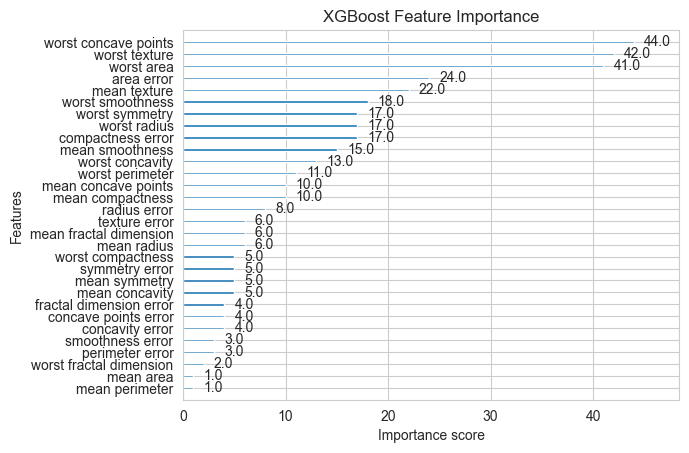

In [7]:
import xgboost as xgb
import pandas as pd
from sklearn import metrics

print(f"XGBoost version: {xgb.__version__}")

# --- XGBoost for Classification (Manual Early Stopping via Booster API) ---

# Convert data to DMatrix (required for Booster API)
dtrain = xgb.DMatrix(X_train_c, label=y_train_c)
dtest = xgb.DMatrix(X_test_c, label=y_test_c)

# Parameters dictionary (sklearn params mapped to XGBoost)
params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'eval_metric': 'logloss',
    'seed': 42,
}

# Early stopping with Booster
evals = [(dtrain, 'train'), (dtest, 'eval')]
booster = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=False
)

print("\nXGBoost Booster trained.")
if hasattr(booster, 'best_iteration'):
    print(f"Best iteration (due to early stopping): {booster.best_iteration}")

# Predictions (get label and probability)
y_pred_xgb_c = (booster.predict(dtest, iteration_range=(0, booster.best_iteration + 1)) > 0.5).astype(int)
y_pred_proba_xgb_c = booster.predict(dtest, iteration_range=(0, booster.best_iteration + 1))

# Evaluation
accuracy_xgb_c = metrics.accuracy_score(y_test_c, y_pred_xgb_c)
roc_auc_xgb_c = metrics.roc_auc_score(y_test_c, y_pred_proba_xgb_c)
print(f"\nXGBoost Classification - Test Accuracy: {accuracy_xgb_c:.4f}")
print(f"XGBoost Classification - Test ROC AUC: {roc_auc_xgb_c:.4f}")
# print("\nClassification Report (XGBoost):")
# print(metrics.classification_report(y_test_c, y_pred_xgb_c, target_names=target_names_cancer))

# Feature Importance
importance_dict = booster.get_score(importance_type='weight')
feature_importances_xgb = pd.Series(importance_dict).sort_values(ascending=False)

print("\nTop 10 XGBoost Feature Importances:\n", feature_importances_xgb.head(10))

# Optionally, plot importances
import matplotlib.pyplot as plt
xgb.plot_importance(booster)
plt.title("XGBoost Feature Importance")
plt.show()


In [8]:
import xgboost as xgb
import pandas as pd
from sklearn import metrics

print(f"XGBoost version: {xgb.__version__}")

# --- XGBoost for Regression (Compatible with all XGBoost versions) ---
dtrain_r = xgb.DMatrix(X_train_r, label=y_train_r)
dtest_r = xgb.DMatrix(X_test_r, label=y_test_r)

params_r = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'eval_metric': 'rmse'
}

evals_r = [(dtrain_r, 'train'), (dtest_r, 'eval')]

xgb_regressor_boost = xgb.train(
    params_r,
    dtrain_r,
    num_boost_round=100,
    evals=evals_r,
    early_stopping_rounds=10,
    verbose_eval=False
)

print("\nXGBoost Regressor trained.")
if hasattr(xgb_regressor_boost, 'best_iteration'):
    print(f"Best iteration (due to early stopping): {xgb_regressor_boost.best_iteration}")

# Predictions and evaluation
y_pred_xgb_r = xgb_regressor_boost.predict(dtest_r, iteration_range=(0, xgb_regressor_boost.best_iteration + 1))
mse_xgb_r = metrics.mean_squared_error(y_test_r, y_pred_xgb_r)
r2_xgb_r = metrics.r2_score(y_test_r, y_pred_xgb_r)
print(f"\nXGBoost Regression - Test MSE: {mse_xgb_r:.4f}")
print(f"XGBoost Regression - Test R²: {r2_xgb_r:.4f}")

# Feature Importance
importance_dict_r = xgb_regressor_boost.get_score(importance_type='weight')
feature_importances_xgb_r = pd.Series(importance_dict_r).sort_values(ascending=False)
# print("\nTop 10 XGBoost Regression Feature Importances:\n", feature_importances_xgb_r.head(10))


XGBoost version: 3.0.2

XGBoost Regressor trained.
Best iteration (due to early stopping): 16

XGBoost Regression - Test MSE: 0.2956
XGBoost Regression - Test R²: 0.4913


## 2. LightGBM (Light Gradient Boosting Machine)

LightGBM is another gradient boosting framework by Microsoft that uses tree-based learning algorithms. It is designed to be distributed and efficient with the following advantages:

### Key Features & Advantages:
* **Speed and Efficiency:** Generally faster training speed and lower memory usage compared to XGBoost, especially on large datasets.
* **Leaf-wise Tree Growth:** XGBoost grows trees level-wise (depth-wise). LightGBM grows trees leaf-wise (best-first). This can lead to more complex trees and potential overfitting if not controlled (`num_leaves` is a key parameter), but often converges faster to better results.
* **Gradient-based One-Side Sampling (GOSS):** A novel sampling method that keeps instances with large gradients (more "error") and randomly drops instances with small gradients. This focuses training on harder-to-learn examples.
* **Exclusive Feature Bundling (EFB):** Bundles mutually exclusive features (features that rarely take non-zero values simultaneously) to reduce dimensionality.
* **Categorical Feature Support:** Can handle categorical features directly (by specifying `categorical_feature` parameter) without needing one-hot encoding, often leading to better performance and speed.
* **Parallel Learning Capabilities.**

LightGBM version: 4.6.0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warni

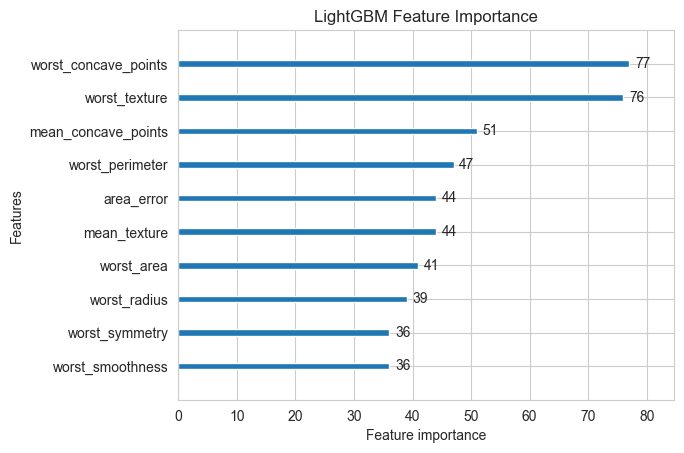

In [10]:
import lightgbm as lgb
import pandas as pd
from sklearn import metrics

print(f"LightGBM version: {lgb.__version__}")

# --- LightGBM for Classification ---
lgbm_classifier = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    lambda_l1=0,
    lambda_l2=0,
    random_state=42,
    n_jobs=-1
)

# LightGBM prefers validation set as a list of tuples (X_val, y_val)
eval_set_lgbm = [(X_test_c, y_test_c)]

# Early stopping callback is robust for all recent LightGBM versions
lgbm_classifier.fit(
    X_train_c, y_train_c,
    eval_set=eval_set_lgbm,
    callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
)

print("\nLightGBM Classifier trained.")
if hasattr(lgbm_classifier, 'best_iteration_'):
    print(f"Best iteration (due to early stopping): {lgbm_classifier.best_iteration_}")

# Predictions
y_pred_lgbm_c = lgbm_classifier.predict(X_test_c)
y_pred_proba_lgbm_c = lgbm_classifier.predict_proba(X_test_c)[:, 1]

# Evaluation
accuracy_lgbm_c = metrics.accuracy_score(y_test_c, y_pred_lgbm_c)
roc_auc_lgbm_c = metrics.roc_auc_score(y_test_c, y_pred_proba_lgbm_c)
print(f"\nLightGBM Classification - Test Accuracy: {accuracy_lgbm_c:.4f}")
print(f"LightGBM Classification - Test ROC AUC: {roc_auc_lgbm_c:.4f}")

# Feature Importance
# Automatically supports both DataFrame and numpy input
if hasattr(X_cancer, 'columns'):
    feature_names = X_cancer.columns
else:
    feature_names = [f"f{i}" for i in range(X_cancer.shape[1])]

feature_importances_lgbm = pd.Series(lgbm_classifier.feature_importances_, index=feature_names).sort_values(ascending=False)
# print("\nTop 10 LightGBM Feature Importances:\n", feature_importances_lgbm.head(10))

# Optional: Plot importances
import matplotlib.pyplot as plt
lgb.plot_importance(lgbm_classifier, max_num_features=10)
plt.title("LightGBM Feature Importance")
plt.show()


LightGBM version: 4.6.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 1
[LightGBM] [Info] Start training from score 0.312891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/opt/anaconda3/envs/ml_explorer/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


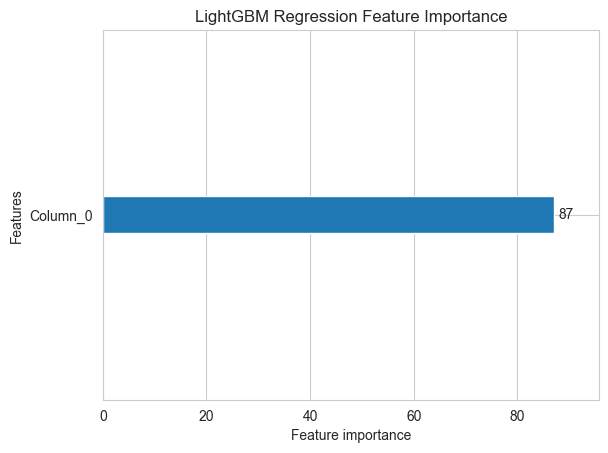

In [11]:
import lightgbm as lgb
import pandas as pd
from sklearn import metrics

print(f"LightGBM version: {lgb.__version__}")

# --- LightGBM for Regression ---
lgbm_regressor = lgb.LGBMRegressor(
    objective='regression_l2',    # MSE loss
    metric='mse',
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

# Early stopping with callback (best practice and compatible)
eval_set_lgbm_r = [(X_test_r, y_test_r)]
lgbm_regressor.fit(
    X_train_r, y_train_r,
    eval_set=eval_set_lgbm_r,
    callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
)

print("\nLightGBM Regressor trained.")
if hasattr(lgbm_regressor, 'best_iteration_'):
    print(f"Best iteration (due to early stopping): {lgbm_regressor.best_iteration_}")

# Predictions
y_pred_lgbm_r = lgbm_regressor.predict(X_test_r)
mse_lgbm_r = metrics.mean_squared_error(y_test_r, y_pred_lgbm_r)
r2_lgbm_r = metrics.r2_score(y_test_r, y_pred_lgbm_r)
print(f"\nLightGBM Regression - Test MSE: {mse_lgbm_r:.4f}")
print(f"LightGBM Regression - Test R²: {r2_lgbm_r:.4f}")

# Feature Importance
if hasattr(X_train_r, 'columns'):
    feature_names = X_train_r.columns
else:
    feature_names = [f"f{i}" for i in range(X_train_r.shape[1])]
feature_importances_lgbm_r = pd.Series(lgbm_regressor.feature_importances_, index=feature_names).sort_values(ascending=False)
# print("\nTop 10 LightGBM Regression Feature Importances:\n", feature_importances_lgbm_r.head(10))

# Optional: Plot importances
import matplotlib.pyplot as plt
lgb.plot_importance(lgbm_regressor, max_num_features=10)
plt.title("LightGBM Regression Feature Importance")
plt.show()


## 3. CatBoost (Categorical Boosting)

CatBoost is a gradient boosting library developed by Yandex. It is particularly well-known for its excellent handling of **categorical features** and often delivers great results with minimal hyperparameter tuning.

### Key Features & Advantages:
* **Superior Categorical Feature Handling:** Uses a combination of one-hot encoding for low-cardinality features and an efficient target-based encoding method (ordered boosting / target statistics) for high-cardinality features. This often outperforms traditional pre-processing.
* **Symmetric Trees (Oblivious Trees):** Grows "oblivious" decision trees, where the same splitting criterion is used for all nodes at the same level. This makes trees more balanced, less prone to overfitting, and faster to execute.
* **Reduced Overfitting:** Techniques like ordered boosting and oblivious trees help combat overfitting.
* **Good Default Parameters:** Often performs well out-of-the-box.
* **Ease of Use:** Simple API, good visualization tools.
* **Handles Missing Values:** Can process missing values internally.

In [15]:
import catboost
from catboost import CatBoostClassifier, Pool
import pandas as pd
from sklearn import metrics

print(f"CatBoost version: {catboost.__version__}")


# --- CatBoost for Classification ---
# CatBoost works best when you specify categorical features; use column indices or names
categorical_features_indices = []  # e.g., np.where(X_train_c.dtypes == 'object')[0]

cb_classifier = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=0
)

# CatBoost uses Pool for evaluation, even if no categorical features
eval_pool = Pool(X_test_c, y_test_c, cat_features=categorical_features_indices)
cb_classifier.fit(
    X_train_c, y_train_c,
    eval_set=eval_pool,
    early_stopping_rounds=10,
    cat_features=categorical_features_indices
)

print("\nCatBoost Classifier trained.")
print(f"Best iteration (due to early stopping): {cb_classifier.get_best_iteration()}")

# Predictions
y_pred_cb_c = cb_classifier.predict(X_test_c)
y_pred_proba_cb_c = cb_classifier.predict_proba(X_test_c)[:, 1]

# Evaluation
accuracy_cb_c = metrics.accuracy_score(y_test_c, y_pred_cb_c)
roc_auc_cb_c = metrics.roc_auc_score(y_test_c, y_pred_proba_cb_c)
print(f"\nCatBoost Classification - Test Accuracy: {accuracy_cb_c:.4f}")
print(f"CatBoost Classification - Test ROC AUC: {roc_auc_cb_c:.4f}")

# Feature Importance
if hasattr(X_cancer, "columns"):
    feature_names_cb = X_cancer.columns
else:
    feature_names_cb = [f"f{i}" for i in range(X_cancer.shape[1])]
feature_importances_cb = pd.Series(cb_classifier.get_feature_importance(), index=feature_names_cb).sort_values(ascending=False)
print("\nTop 10 CatBoost Feature Importances:\n", feature_importances_cb.head(10))


CatBoost version: 1.2.8

CatBoost Classifier trained.
Best iteration (due to early stopping): 58

CatBoost Classification - Test Accuracy: 0.9532
CatBoost Classification - Test ROC AUC: 0.9961

Top 10 CatBoost Feature Importances:
 worst area              14.019769
worst concave points    12.579250
worst texture           10.315663
worst smoothness         6.749012
worst radius             5.892965
worst perimeter          5.788978
mean texture             4.244849
radius error             4.025736
worst concavity          3.620698
mean perimeter           2.435345
dtype: float64


In [14]:
from catboost import CatBoostRegressor, Pool

# --- CatBoost for Regression ---
cb_regressor = CatBoostRegressor(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=0
)

eval_pool_r = Pool(X_test_r, y_test_r)
cb_regressor.fit(
    X_train_r, y_train_r,
    eval_set=eval_pool_r,
    early_stopping_rounds=10
)

print("\nCatBoost Regressor trained.")
print(f"Best iteration (due to early stopping): {cb_regressor.get_best_iteration()}")

y_pred_cb_r = cb_regressor.predict(X_test_r)
mse_cb_r = metrics.mean_squared_error(y_test_r, y_pred_cb_r)
r2_cb_r = metrics.r2_score(y_test_r, y_pred_cb_r)
print(f"\nCatBoost Regression - Test MSE: {mse_cb_r:.4f}")
print(f"CatBoost Regression - Test R²: {r2_cb_r:.4f}")

# Feature Importance (optional, if you want to match the workflow)
if hasattr(X_train_r, "columns"):
    feature_names_cb_r = X_train_r.columns
else:
    feature_names_cb_r = [f"f{i}" for i in range(X_train_r.shape[1])]
feature_importances_cb_r = pd.Series(cb_regressor.get_feature_importance(), index=feature_names_cb_r).sort_values(ascending=False)
print("\nTop 10 CatBoost Regression Feature Importances:\n", feature_importances_cb_r.head(10))



CatBoost Regressor trained.
Best iteration (due to early stopping): 22

CatBoost Regression - Test MSE: 0.2721
CatBoost Regression - Test R²: 0.5317

Top 10 CatBoost Regression Feature Importances:
 f0    100.0
dtype: float64


## 4. Brief Comparison & When to Use Which

| Feature                | XGBoost                                  | LightGBM                                   | CatBoost                                      |
|------------------------|------------------------------------------|--------------------------------------------|-----------------------------------------------|
| **Speed** | Fast, good for medium datasets          | Very Fast, excels on large datasets        | Can be slower than LightGBM but often faster than Scikit-learn GBM |
| **Accuracy** | High, often state-of-the-art            | High, often state-of-the-art              | High, often state-of-the-art                 |
| **Categorical Data** | Requires pre-processing (e.g., one-hot) | Can handle directly (efficiently)         | Excels with direct handling (ordered TS)    |
| **Missing Values** | Handles internally                       | Handles internally                         | Handles internally                             |
| **Tree Growth** | Level-wise                               | Leaf-wise (can be faster, risk of overfit if not tuned) | Oblivious (symmetric) trees                   |
| **Ease of Tuning** | Many parameters, requires tuning        | Many parameters, requires tuning          | Often good defaults, less tuning needed      |
| **Memory Usage** | Moderate                                 | Low                                        | Moderate to high (can depend on cat features) |
| **Regularization** | L1/L2, gamma                             | L1/L2                                      | L2, border_count, others                      |
| **Overfitting** | Good control with tuning                 | Good control, `num_leaves` important     | Often robust, ordered boosting helps         |

**General Guidelines:**
* **Large Datasets & Speed Critical:** LightGBM is often a first choice.
* **Datasets with Many Categorical Features:** CatBoost is excellent.
* **Robustness & Widespread Use:** XGBoost is a very solid, well-established choice with a large community.
* **Minimal Tuning Desired:** CatBoost often performs well with default settings.

It's always recommended to try multiple libraries and tune their hyperparameters for your specific dataset and problem.

## 5. Aggregated Results (Example)

Let's quickly summarize the classification accuracies we got on the Breast Cancer dataset (these are from a single run and without extensive tuning, so they are illustrative):

In [16]:
import pandas as pd

# -- Classification Results Summary --
results_summary = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'CatBoost'],
    'Accuracy': [accuracy_xgb_c, accuracy_lgbm_c, accuracy_cb_c],
    'ROC AUC': [roc_auc_xgb_c, roc_auc_lgbm_c, roc_auc_cb_c]
})
results_summary = results_summary.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
print("\n--- Classification Performance Summary (Breast Cancer Dataset) ---")
print(results_summary)

# -- Regression Results Summary --
results_summary_reg = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'CatBoost'],
    'MSE': [mse_xgb_r, mse_lgbm_r, mse_cb_r],
    'R2 Score': [r2_xgb_r, r2_lgbm_r, r2_cb_r]
})
results_summary_reg = results_summary_reg.sort_values(by='MSE', ascending=True).reset_index(drop=True)
print("\n--- Regression Performance Summary (Synthetic Dataset) ---")
print(results_summary_reg)



--- Classification Performance Summary (Breast Cancer Dataset) ---
      Model  Accuracy   ROC AUC
0  LightGBM  0.959064  0.992407
1   XGBoost  0.953216  0.994597
2  CatBoost  0.953216  0.996057

--- Regression Performance Summary (Synthetic Dataset) ---
      Model       MSE  R2 Score
0  CatBoost  0.272093  0.531671
1   XGBoost  0.295553  0.491292
2  LightGBM  0.309115  0.467950


## Conclusion & Key Takeaways

* XGBoost, LightGBM, and CatBoost are highly optimized and powerful gradient boosting libraries that often deliver superior performance compared to standard GBM implementations.
* Each library has its unique strengths:
    * **XGBoost:** Robust, feature-rich, widely adopted.
    * **LightGBM:** Extremely fast, memory efficient, great for large datasets, uses leaf-wise growth.
    * **CatBoost:** Excellent handling of categorical features, often good with defaults, uses oblivious trees.
* All three support regularization, early stopping, and can handle missing values.
* They are indispensable tools for working with structured/tabular data in both competitive and production machine learning environments.
* The choice of library can depend on the specific characteristics of the dataset (size, presence of categorical features), computational resources, and the need for speed vs. out-of-the-box performance.

## Further Reading/References (Optional)

* **XGBoost:**
    * [Documentation](https://xgboost.readthedocs.io/)
    * [Paper by Chen & Guestrin (2016)](https://arxiv.org/abs/1603.02754)
* **LightGBM:**
    * [Documentation](https://lightgbm.readthedocs.io/)
    * [Paper by Ke et al. (2017)](https://proceedings.neurips.cc/paper/2017/hash/6449f44a102fde848669bdd9eb6b76fa-Abstract.html)
* **CatBoost:**
    * [Documentation](https://catboost.ai/docs/)
    * [Paper by Prokhorenkova et al. (2018) - on ordered boosting](https://arxiv.org/abs/1706.09516)
    * [Paper by Dorogush et al. (2018) - CatBoost library](https://arxiv.org/abs/1810.11363)
* Many blog posts and Kaggle discussions compare these libraries in detail.